In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [865]:
mpl.rcParams['font.size'] = 16

In [862]:
%matplotlib inline

# Data Preprocessing:

In [2]:
inp_file = '../../WNTR_Model/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py36_WNTR/lib/python3.6/site-packages/wntr/epanet/io.py:2085: UserWarning:

Not all curves were used in "../../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [870]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_20.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Junctions:
Pressure and demand.

In [871]:
junction_pressure = results.node['pressure'][node_names[2]]
junction_pressure.shape

(721, 378)

In [872]:
junction_demand = results.node['demand'][node_names[2]]

## Tank levels:

In [873]:
tank_level = results.node['pressure'][node_names[0]]
tank_level.shape

(721, 7)

## Pumps:

In [874]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]
head_pump_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

head_pump_speed_corr = head_pump_speed*head_pump_status

In [875]:
pump_energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)[link_names[0]]
pump_energy /= 1000
pump_energy.head(3)

,PU2,PU5,PU6,PU8,PU10
0,60.822807,30.464355,57.864492,30.483825,20.220473
3600,0.000000,20.254011,0.000000,140.423315,18.685029
7200,0.000000,8.411362,0.000000,140.851250,18.692351


## Valves

In [876]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

PRValve_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle_status = results.link['status'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

## Neural Network Pre-Processing
### NN inputs:

In [877]:
input_1_dict = {
    'junction_demand': junction_demand
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level,
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'head_pump_speed': head_pump_speed_corr,             
    'PRValve_dp': PRValve_dp,          
    'TCValve_throttle': TCValve_throttle
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                    \
     junction_demand                                                     
name            J511      J411      J414 J415 J416      J417 J418 J419   
0           0.000674  0.000343  0.000373  0.0  0.0  0.000498  0.0  0.0   
3600        0.000497  0.000331  0.000359  0.0  0.0  0.000480  0.0  0.0   

                          ...     states          inputs                 \
                          ... tank_level head_pump_speed                  
name      J310      J311  ...         T4             PU2       PU5  PU6   
0     0.000861  0.000749  ...   4.253243             1.0  1.000000  1.0   
3600  0.000616  0.000536  ...   4.619482             0.0  0.891542  0.0   

                                                                              
                         PRValve_dp                         TCValve_throttle  
name      PU8      PU10          V1         V45         V47               V2  
0     1.00000  1.000000  252.667465  186.424881  275.811829         2.342316  
3600  1.69712  0.940152  252.667465  186.424881  275.811829         2.342316  

[2 rows x 394 columns]

### NN outputs:

In [878]:
dtank_level = tank_level.diff(axis=0)
dtank_level_next = dtank_level.shift(-1, axis=0)

output_1_dict ={
    'junction_pressure': junction_pressure,
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_energy': pump_energy,
}

output_3_dict = {
    'dtank_level_next': dtank_level_next,
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                               \
     junction_pressure                                                
name              J511       J411       J414       J415        J416   
0            31.758253  66.665215  37.161221  87.117256  101.653847   
3600         31.574421  60.240513  34.568108  68.530624   90.930618   

                                                             ...      energy  \
                                                             ... pump_energy   
name       J417       J418       J419       J310       J311  ...         PU6   
0     32.781761  31.722605  28.282461  54.578266  50.491978  ...   57.729275   
3600  31.470657  31.408619  28.291861  54.587486  50.490238  ...  266.693973   

                                    dstates                                \
                           dtank_level_next                                 
name        PU8       PU10               T3        T1        T7        T6   
0     30.484445  19.474339         0.468762 -0.200881  0.167227  0.243436   
3600  17.642207   0.000000         0.168167 -0.708961  0.193542  0.182259   

                                    
                                    
name        T5        T2        T4  
0     0.648667  0.070898  0.366238  
3600  1.863579 -0.001981 -0.957142  

[2 rows x 397 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [879]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=720, n_inputs = 394, n_outputs=397


In [830]:
input_scaling = nn_input.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input/input_scaling

output_scaling = nn_output.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [831]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
nonnegunit_cons =  nonnegUnitNorm(axis=1)

l1_penalty = tf.keras.regularizers.l1(l=0.001)
l2_penalty = tf.keras.regularizers.l2(l=0.1)

In [833]:
n_cluster = 30

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')
tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=False, 
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
tf_interm = tf.keras.layers.Dense(50, activation=tf.nn.tanh, name='interm_1')(tf_in_cat)
tf_interm = tf.keras.layers.Dense(50, activation=tf.nn.tanh, name='interm_2')(tf_interm)
tf_interm = tf.keras.layers.Dense(50, activation=tf.nn.tanh, name='interm_3')(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    #kernel_constraint=nonneg_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)
tf_out_3 = tf.keras.layers.Dense(nn_output['dstates'].shape[1], name='dstates_out')(tf_interm_2)


In [834]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [835]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [838]:
%%capture
history = model.fit([nn_input_scaled['demand'], nn_input_scaled['states'], nn_input_scaled['inputs']], 
                    [nn_output_scaled['pressure'], nn_output_scaled['energy'], nn_output_scaled['dstates']], 
                    batch_size=50, 
                    epochs=1000)

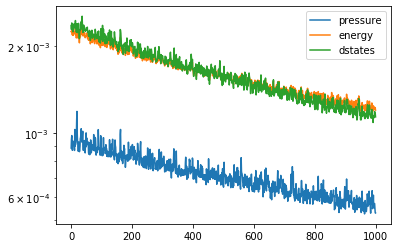

In [839]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['dstates_out_loss'], label='dstates')
plt.legend()

In [698]:
A_cluster = model.get_layer('cluster_demand').get_weights()[0]

### Simulation evaluation

In [840]:
from IPython.display import clear_output, display

In [880]:
demand = nn_input['demand'].to_numpy()
states = nn_input['states'].to_numpy()
inputs = nn_input['inputs'].to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

pressure = nn_output['pressure'].to_numpy()
energy = nn_output['energy'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

In [881]:
for k in range(states.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = demand[[k],:]
    states_k = states[[k],:]
    inputs_k = inputs[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    
    energy[[k],:] = energy_k
    pressure[[k],:] = pressure_k
    states[[k+1],:] = states_k_next

718


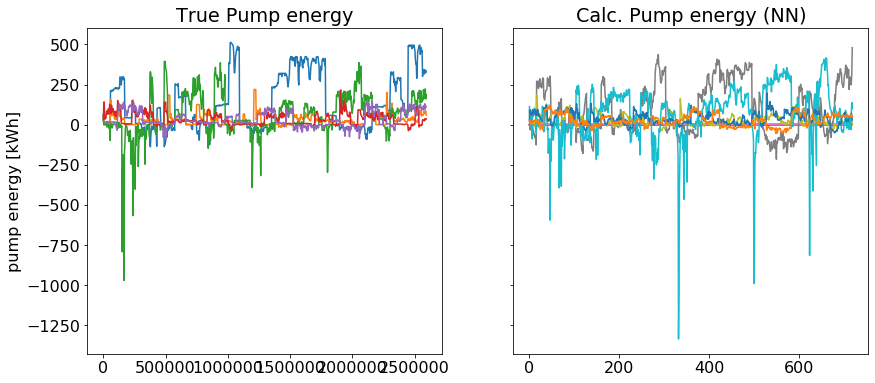

In [882]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
pump_energy.plot(legend=False, ax=ax[0])
ax[1].plot(energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')
plt.show()

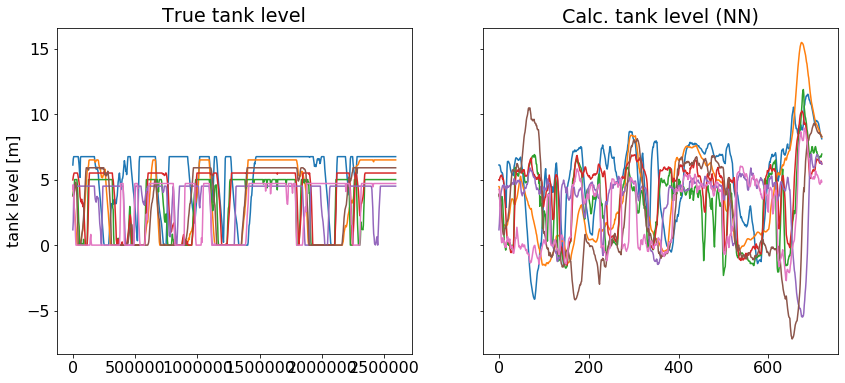

In [883]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
tank_level.plot(legend=False, ax=ax[0])
ax[1].plot(states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')
plt.show()

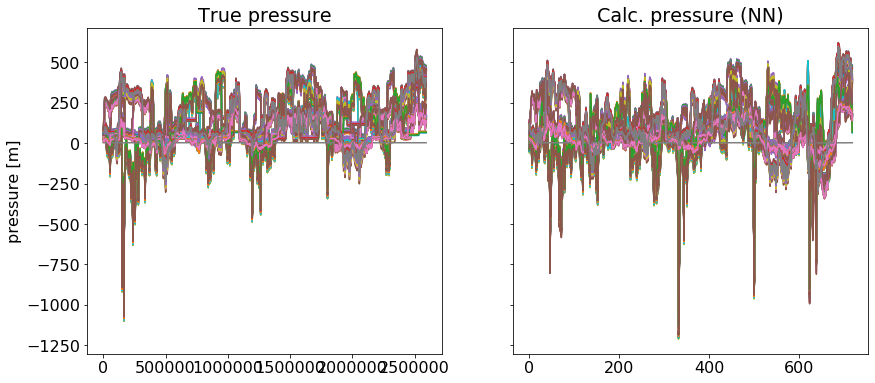

In [884]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
junction_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
plt.show()